Для обучения используется датасет комментариев из соцсетей, размеченных людьми  
http://sentistrength.wlv.ac.uk/documentation/

In [45]:
import pandas as pd

df = pd.read_csv("datasets/human_classified_sn.csv", usecols=['text','target'] )

Датасет с коментариями на русском языке   
http://study.mokoron.com/

In [37]:
pos = pd.read_csv("datasets/positive.csv", sep=";", usecols=['ttext','ttype'])
neg = pd.read_csv("datasets/negative.csv", sep=";", usecols=['ttext','ttype'])

df = pd.concat([pos,neg])
df.columns = ['text', 'target']
df['target'] = np.where(df.target == 1, 1, 0)

In [38]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


df['text'] = [preprocess_text(t) for t in df.text]

Дальнейший анализ можно проводить для обоих датасетов:

In [46]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(df, train_size = 0.8)
X_train, Y_train = train.text, train.target
X_validation, Y_validation = validation.text, validation.target

На обучающей выборке с помощбю кросс-валидации подберем пару преобразователь-модель, дающую лучшее качество auc_roc (данная метрика не зависит от выбора разделяющей границы, что может быть полезно в случае не сбалансированных классов)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

vectorizers = {"count" : CountVectorizer(), "tfidf" : TfidfVectorizer()}
models = {"logistic" : LogisticRegression(max_iter = 10000), "svm" : LinearSVC(max_iter=10000),'knn' : KNeighborsClassifier(metric='cosine') }

for vect_name, vect in vectorizers.items():
    for model_name, model in models.items():
        pipe = Pipeline([('vectorizer', vect), ('model', model)])
        cv_score = cross_val_score(pipe, X_train, Y_train, scoring='roc_auc')
        print("({} + {}) score is {}".format(vect_name, model_name, cv_score.mean()))

(count + logistic) score is 0.8142632809336648
(count + svm) score is 0.7923563823274714
(count + knn) score is 0.7056785759275633
(tfidf + logistic) score is 0.8285221016907037
(tfidf + svm) score is 0.820019152626734
(tfidf + knn) score is 0.7517912282217489


Лучшее качество дает TfIdf векторизатор и логистическая регрессия. Дальше будем подбирать гиперпараметры. Подберем коэффициент регуляризации для регрессии

In [48]:
from sklearn.linear_model import LogisticRegressionCV

cv_selection = Pipeline([('vectorizer', TfidfVectorizer()), ('model', LogisticRegressionCV(max_iter = 1000, scoring='roc_auc'))])
cv_selection.fit(X_train, Y_train)
model = cv_selection.named_steps['model']
best_C = model.C_[0]
best_C

2.782559402207126

Посчитаем качество на валидации для оптимального C

In [49]:
from sklearn.metrics import roc_auc_score

pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('model', LogisticRegression(max_iter = 10000, C=best_C))])
pipe.fit(X_train, Y_train)
print(roc_auc_score(Y_validation, pipe.predict_proba(X_validation)[:,1]))

0.8400083429734297


Теперь по валидационной выборке будем подбирать преобразования текста.
Попробуем удалить из текста стоп-слова:

In [50]:
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords

pipe = Pipeline([('vectorizer', TfidfVectorizer(stop_words = stopwords.words("english"))), ('model', LogisticRegression(max_iter = 10000, C=best_C))])
pipe.fit(X_train, Y_train)
print(roc_auc_score(Y_validation, pipe.predict_proba(X_validation)[:,1]))

0.8269082848300213


Попробуем приводить слова к начальной форме

In [51]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
def stem(data):
    return data.apply(lambda x : stemmer.stem(x))

pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('model', LogisticRegression(max_iter = 10000, C=best_C))])
pipe.fit(stem(X_train), Y_train)
print(roc_auc_score(Y_validation, pipe.predict_proba(stem(X_validation))[:,1]))

0.8391971364371416


Попробуем рассматривать в качестве признаков также наборы слов

In [52]:
from sklearn.metrics import roc_auc_score

pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,2))), ('model', LogisticRegression(max_iter = 10000, C=best_C))])
pipe.fit(X_train, Y_train)
print(roc_auc_score(Y_validation, pipe.predict_proba(X_validation)[:,1]))

0.8386471209927987


В итоге лучшее качество на валидации дает рассматривание слов и словосочетаний исходных текстов (без 
лемматизации и удаления стоп-слов)
Посмотрим на зависимость точности от границы разделения классов и выберем оптимальную границу

<AxesSubplot:>

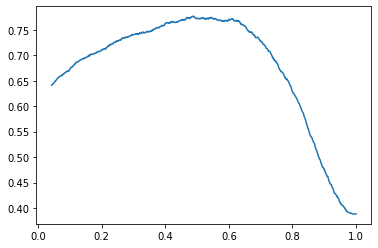

In [53]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range=(1,2))), ('model', LogisticRegression(C=best_C, max_iter = 10000))])
pipe.fit(X_train, Y_train)
validate_prediction = pipe.predict_proba(X_validation)
precision, recall, thresh = precision_recall_curve(Y_validation, validate_prediction[:,1])
acc = np.array([accuracy_score(Y_validation, np.where(validate_prediction[:,0] > tr, 0, 1)) for tr in thresh])
best_threshold = thresh[acc.argmax()]
sns.lineplot(x=thresh, y=acc)

In [54]:
pipe.best_threshold = best_threshold

Сохраняем модель

In [55]:
from pickle import dump
with open("model.pkl", 'wb') as file:
    dump(pipe, file)